In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 64
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class ZFNet(nn.Module):
    """ A implementation of the ZFNet architecture from the paper 'Visualizing and 
        Understanding Convolutional Networks' by Zeiler and Fergus"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, padding_mode='reflect') 
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2, padding_mode='reflect')
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.fc6 = nn.Linear(9216,4096)
        self.fc7 = nn.Linear(4096,4096)
        self.fc8 = nn.Linear(4096,num_classes)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.drop = nn.Dropout(0.5)
        self.drop = nn.Dropout(0.5)
        self.lrn = nn.LocalResponseNorm(size=5,alpha=10e-4,beta=0.75,k=2.0)

    def forward(self, x):
        x = self.lrn(self.pool1(F.relu(self.conv1(x))))
        x = self.lrn(self.pool2(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(F.relu(self.conv5(x)))
        x = x.view(-1,9216)
        x = F.relu(self.drop(self.fc6(x)))
        x = F.relu(self.drop(self.fc7(x)))
        x = self.fc8(x)
        return x

In [4]:
model = ZFNet(num_classes=10).to(device)

In [5]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 112, 112]          14,208
         MaxPool2d-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
            Conv2d-4          [-1, 256, 28, 28]         614,656
         MaxPool2d-5          [-1, 256, 13, 13]               0
 LocalResponseNorm-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
            Conv2d-8          [-1, 384, 13, 13]       1,327,488
            Conv2d-9          [-1, 256, 13, 13]         884,992
        MaxPool2d-10            [-1, 256, 6, 6]               0
           Linear-11                 [-1, 4096]      37,752,832
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 4096]      16,781,312
          Dropout-14                 [-

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/150] 	 Loss: 1.71538     Accuracy: 36.47% 	 Test Loss: 1.41600     Test Accuracy: 48.30%
Epoch [  2/150] 	 Loss: 1.37770     Accuracy: 50.45% 	 Test Loss: 1.24684     Test Accuracy: 55.67%
Epoch [  3/150] 	 Loss: 1.23797     Accuracy: 55.89% 	 Test Loss: 1.23605     Test Accuracy: 57.05%
Epoch [  4/150] 	 Loss: 1.14273     Accuracy: 59.76% 	 Test Loss: 1.11094     Test Accuracy: 60.77%
Epoch [  5/150] 	 Loss: 1.06057     Accuracy: 62.68% 	 Test Loss: 1.14292     Test Accuracy: 59.00%
Epoch [  6/150] 	 Loss: 0.97882     Accuracy: 65.67% 	 Test Loss: 1.04974     Test Accuracy: 63.89%
Epoch [  7/150] 	 Loss: 0.92624     Accuracy: 67.43% 	 Test Loss: 1.03885     Test Accuracy: 63.77%
Epoch [  8/150] 	 Loss: 0.86210     Accuracy: 69.59% 	 Test Loss: 1.01439     Test Accuracy: 65.59%
Epoch [  9/150] 	 Loss: 0.80977     Accuracy: 71.55% 	 Test Loss: 1.06166     Test Accuracy: 63.12%
Epoch [ 10/150] 	 Loss: 0.75609     Accuracy: 73.25% 	 Test Loss: 0.99456     Test Accuracy: 65.38%


KeyboardInterrupt: 

In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 77 with test accuracy: 67.30%


# Plot results

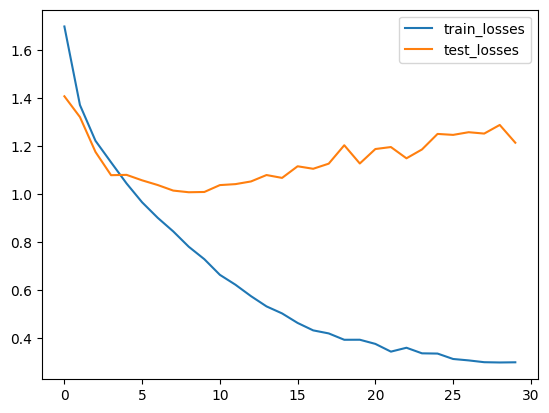

In [ ]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

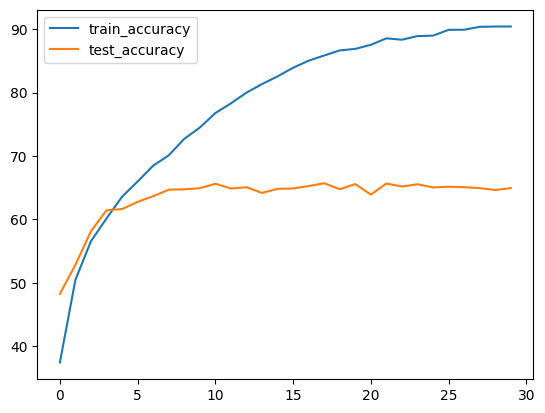

In [ ]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()